In [33]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline
plt.style.use('ggplot')

# Fitting Classification Trees

In [2]:
carseats = pd.read_csv('.\Downloads\Carseats.csv', index_col=0)
carseats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 37.5+ KB


In [3]:
carseats['High'] = np.where(carseats['Sales'] <= 8, 'No', 'Yes')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,No
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No,No


In [4]:
carseats_dummies = pd.get_dummies(carseats, drop_first=True)
carseats_dummies.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,High_Yes
1,9.50,138,73,11,276,120,42,17,0,0,1,1,1
2,11.22,111,48,16,260,83,65,10,1,0,1,1,1
3,10.06,113,35,10,269,80,59,12,0,1,1,1,1
4,7.40,117,100,4,466,97,55,14,0,1,1,1,0
5,4.15,141,64,3,340,128,38,13,0,0,1,0,0


In [5]:
X = carseats_dummies.drop(['Sales', 'High_Yes'], axis=1)
y = carseats_dummies['High_Yes']

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

In [6]:
clf.tree_.node_count

121

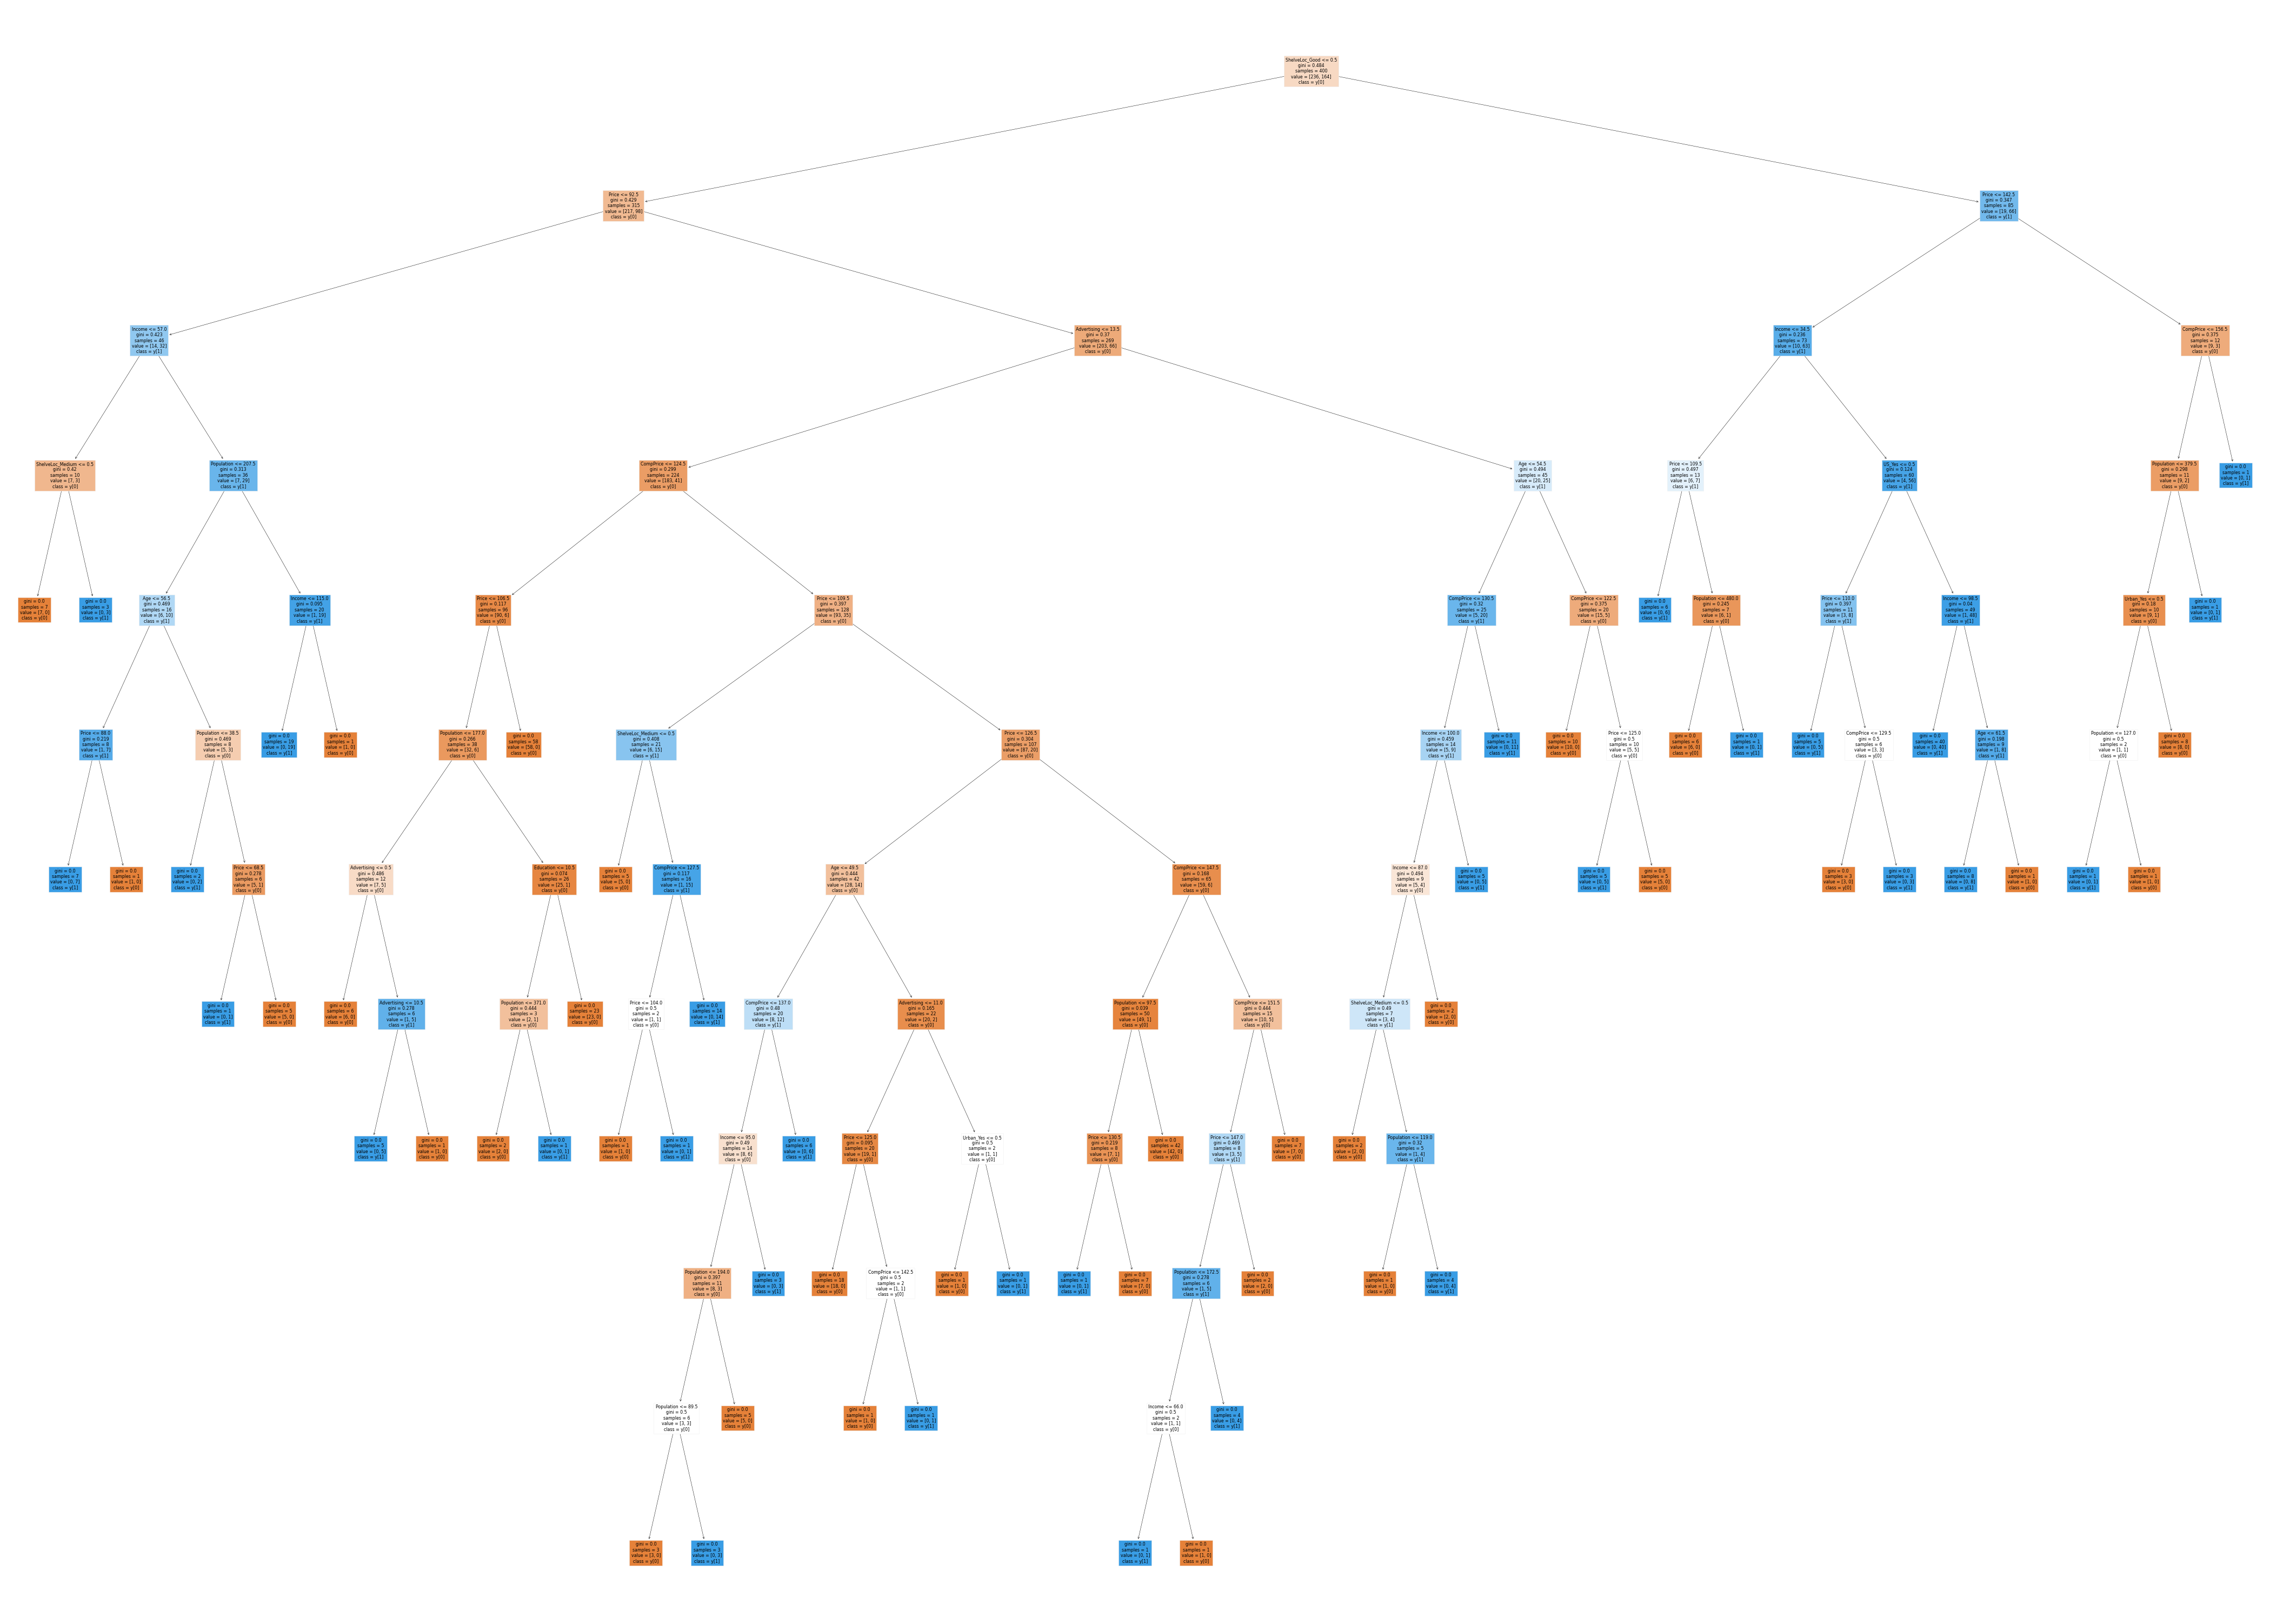

In [7]:
plt.figure(figsize=(75, 55))
tree.plot_tree(clf, feature_names=X.columns, class_names=True, filled=True)

plt.show()

In [8]:
print(tree.export_graphviz(clf, feature_names=X.columns, class_names=True))

digraph Tree {
node [shape=box] ;
0 [label="ShelveLoc_Good <= 0.5\ngini = 0.484\nsamples = 400\nvalue = [236, 164]\nclass = y[0]"] ;
1 [label="Price <= 92.5\ngini = 0.429\nsamples = 315\nvalue = [217, 98]\nclass = y[0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Income <= 57.0\ngini = 0.423\nsamples = 46\nvalue = [14, 32]\nclass = y[1]"] ;
1 -> 2 ;
3 [label="ShelveLoc_Medium <= 0.5\ngini = 0.42\nsamples = 10\nvalue = [7, 3]\nclass = y[0]"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 7\nvalue = [7, 0]\nclass = y[0]"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = y[1]"] ;
3 -> 5 ;
6 [label="Population <= 207.5\ngini = 0.313\nsamples = 36\nvalue = [7, 29]\nclass = y[1]"] ;
2 -> 6 ;
7 [label="Age <= 56.5\ngini = 0.469\nsamples = 16\nvalue = [6, 10]\nclass = y[1]"] ;
6 -> 7 ;
8 [label="Price <= 88.0\ngini = 0.219\nsamples = 8\nvalue = [1, 7]\nclass = y[1]"] ;
7 -> 8 ;
9 [label="gini = 0.0\nsamples = 7\nvalue = [0, 7]\nclass = y[1]"] ;
8

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, shuffle=True, random_state=1)

In [10]:
np.random.seed(1)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

ind = pd.MultiIndex.from_product([['Pred'], ['No', 'Yes']])
cols = pd.MultiIndex.from_product([['True'], ['No', 'Yes']])
pd.DataFrame(confusion_matrix(y_test, pred).T, index=ind, columns=cols)

True    
           No Yes
Pred No    86  32
     Yes   33  49

In [11]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.729     0.723     0.726       119
           1      0.598     0.605     0.601        81

    accuracy                          0.675       200
   macro avg      0.663     0.664     0.663       200
weighted avg      0.676     0.675     0.675       200



In [13]:
kf10 = KFold(n_splits=10, shuffle=True, random_state=1)

mseS = []
for i in range(2, 25):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=i)    
    mseS.append(-cross_val_score(clf, X_train, y_train, cv=kf10, scoring='neg_mean_squared_error').mean())
    
min_ind, min_mse = min(enumerate(mseS), key=itemgetter(1))
min_ind, min_mse

(8, 0.265)

Text(0, 0.5, '10 fold CV-error')

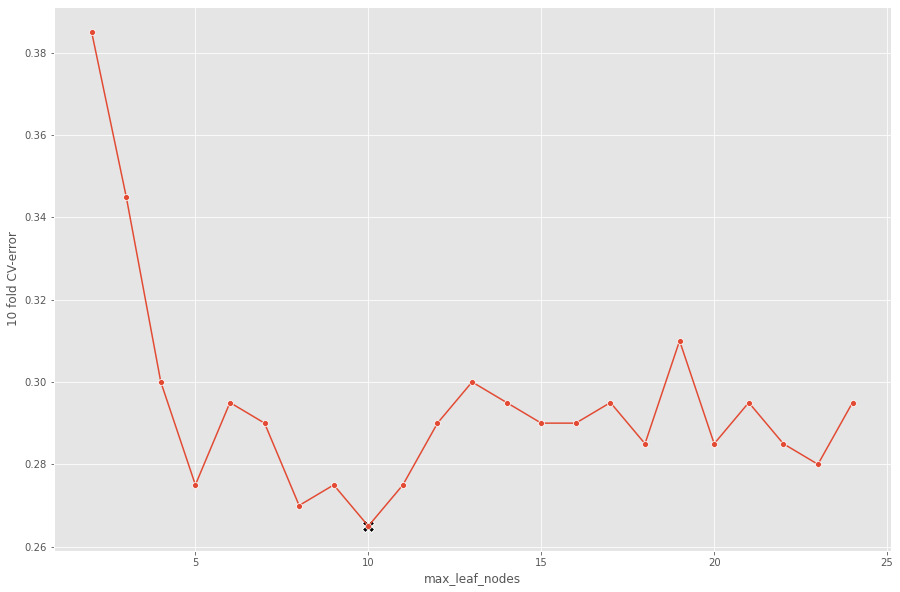

In [14]:
plt.figure(figsize=(15, 10))

sns.lineplot(x=range(2, 25), y=mseS, marker='o')
sns.scatterplot(x=[min_ind+2], y=min_mse, marker='X', s=150, color='k')

plt.xlabel('max_leaf_nodes')
plt.ylabel('10 fold CV-error')

In [16]:
np.random.seed(1)

clf = tree.DecisionTreeClassifier(max_leaf_nodes=min_ind+2)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

ind = pd.MultiIndex.from_product([['Pred'], ['No', 'Yes']])
cols = pd.MultiIndex.from_product([['True'], ['No', 'Yes']])
pd.DataFrame(confusion_matrix(y_test, pred).T, index=ind, columns=cols)

True    
           No Yes
Pred No    99  32
     Yes   20  49

In [17]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.756     0.832     0.792       119
           1      0.710     0.605     0.653        81

    accuracy                          0.740       200
   macro avg      0.733     0.718     0.723       200
weighted avg      0.737     0.740     0.736       200



# Fitting Regression Trees

In [18]:
boston = pd.read_csv('.\Downloads\Boston.csv', index_col=0)
boston.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 506
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


In [19]:
X = boston.drop('medv', axis=1)
y = boston['medv']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, shuffle=True, random_state=1)

In [21]:
regr = tree.DecisionTreeRegressor(max_depth=3)
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [22]:
regr.tree_.node_count

15

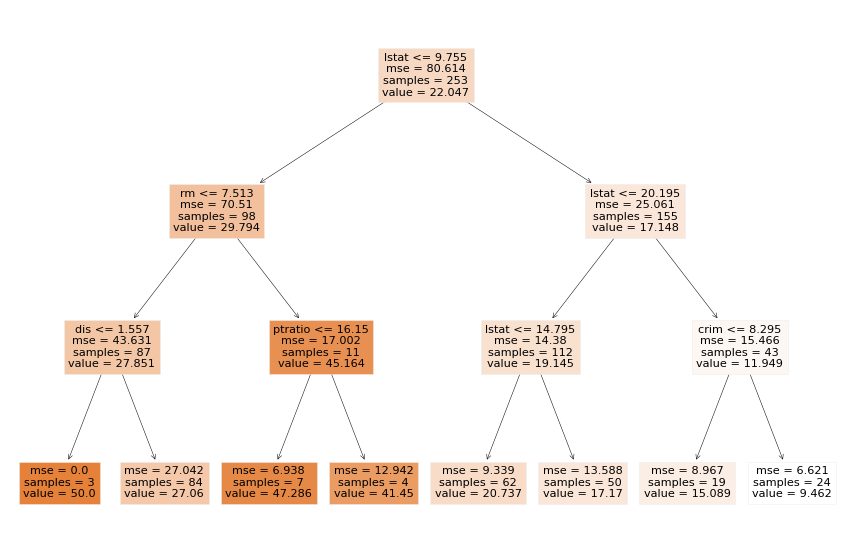

In [23]:
plt.figure(figsize=(15, 10))

tree.plot_tree(regr, feature_names=X.columns, class_names=True, filled=True)

plt.show()

In [24]:
kf10 = KFold(n_splits=10, shuffle=True, random_state=1)

mseS = []
for i in range(2, 25):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=i)
    mseS.append(-cross_val_score(regr, X_train, y_train, cv=kf10, scoring='neg_mean_squared_error').mean())
    
min_ind, min_mse = min(enumerate(mseS), key=itemgetter(1))
min_ind, min_mse

(14, 23.47341687443214)

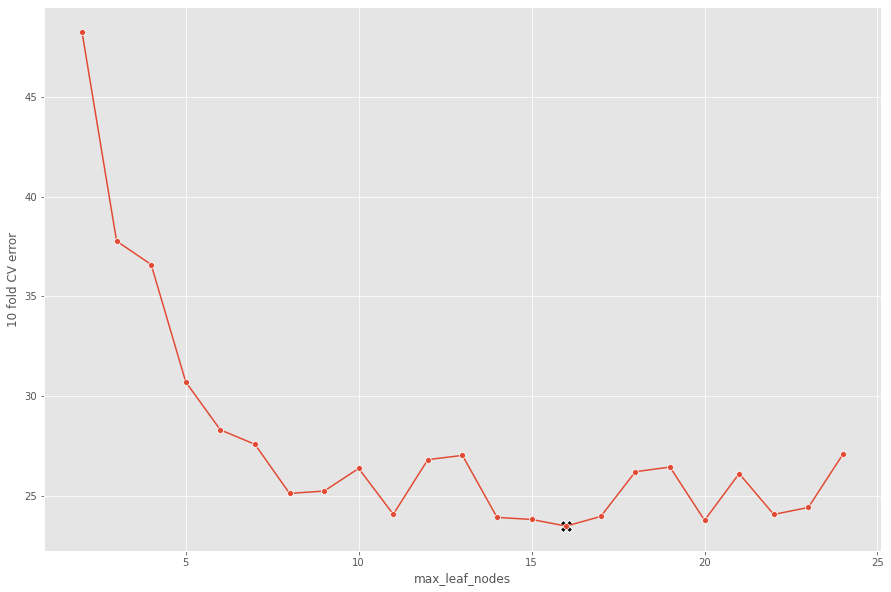

In [25]:
plt.figure(figsize=(15, 10))

sns.lineplot(x=range(2, 25), y=mseS, marker='o')
sns.scatterplot(x=[min_ind+2], y=min_mse, marker='X', s=150, color='k')

plt.xlabel('max_leaf_nodes')
plt.ylabel('10 fold CV error')

plt.show()

In [26]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=min_ind+2)
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=16)

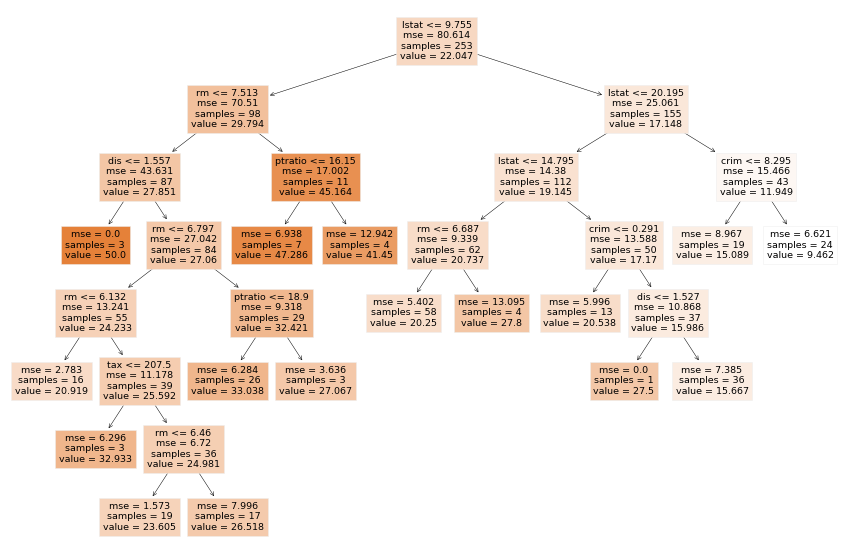

In [27]:
plt.figure(figsize=(15, 10))

tree.plot_tree(regr, feature_names=X.columns, class_names=True, filled=True)

plt.show()

In [28]:
pred = regr.predict(X_test)

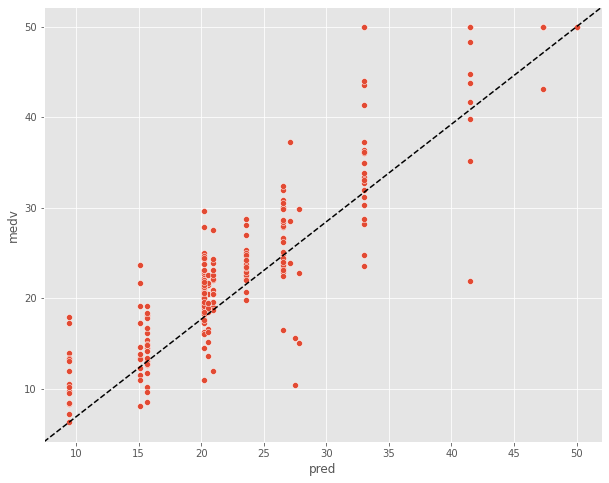

In [29]:
plt.figure(figsize=(10, 8))

sns.scatterplot(x=pred, y=y_test)
sns.lineplot(x=[0, 1], y=[0, 1], ls='--', color='k', transform=plt.gca().transAxes)

plt.xlabel('pred')

plt.show()

In [32]:
mean_squared_error(y_test, pred)

16.977468051391675

# Bagging and Random Forests

In [34]:
X = boston.drop('medv', axis=1)
y = boston['medv']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, shuffle=True, random_state=1)

In [36]:
regr = GradientBoostingRegressor(n_estimators=5000, max_depth=4)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

In [37]:
mean_squared_error(y_test, pred)

10.426598804817651

In [38]:
regr = GradientBoostingRegressor(n_estimators=5000, max_depth=4, learning_rate=.2, verbose=1)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1          54.5263            4.93s
         2          37.6461            4.96s
         3          26.4076            4.97s
         4          18.9033            4.98s
         5          13.9899            4.98s
         6          10.5028            4.98s
         7           8.1524            4.98s
         8           6.5087            4.98s
         9           5.3830            4.98s
        10           4.5313            4.99s
        20           1.4731            4.48s
        30           0.8078            4.47s
        40           0.4542            4.46s
        50           0.2605            4.75s
        60           0.1402            4.61s
        70           0.0891            4.51s
        80           0.0545            4.37s
        90           0.0330            4.36s
       100           0.0209            4.26s
       200           0.0003            3.79s
       300           0.0000            3.79s
       40

In [39]:
mean_squared_error(y_test, pred)

10.2182945385201